In [1]:
## CAMERA CALIBRATION

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(idx)+'.jpg'
        cv2.imwrite('camera_cal/Corners_found/'+write_name, img)
        #cv2.imshow('img', img)
        #cv2.waitKey(500)

cv2.destroyAllWindows()

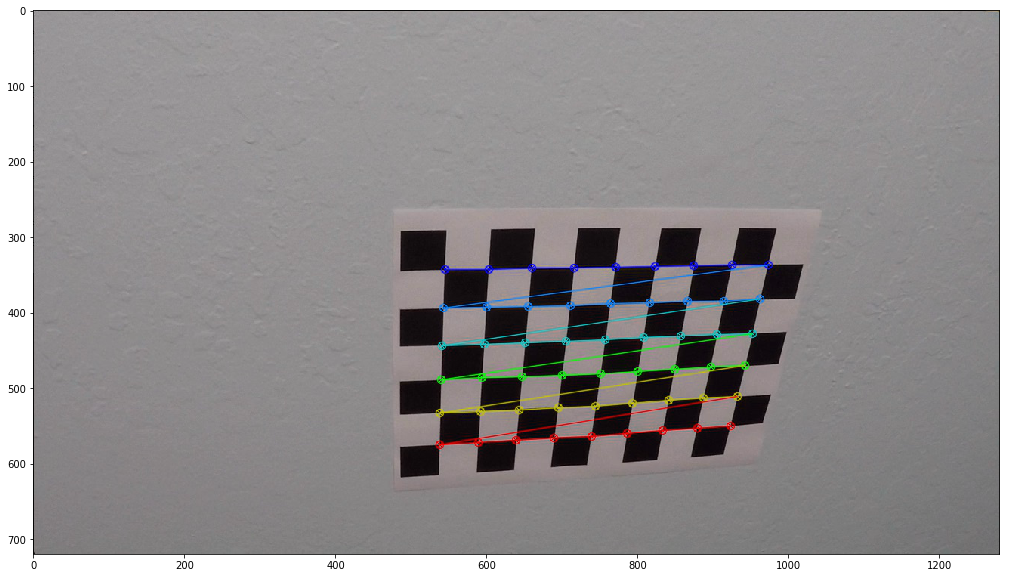

In [2]:
img = cv2.imread('camera_cal/Corners_found/corners_found1.jpg')
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(img)

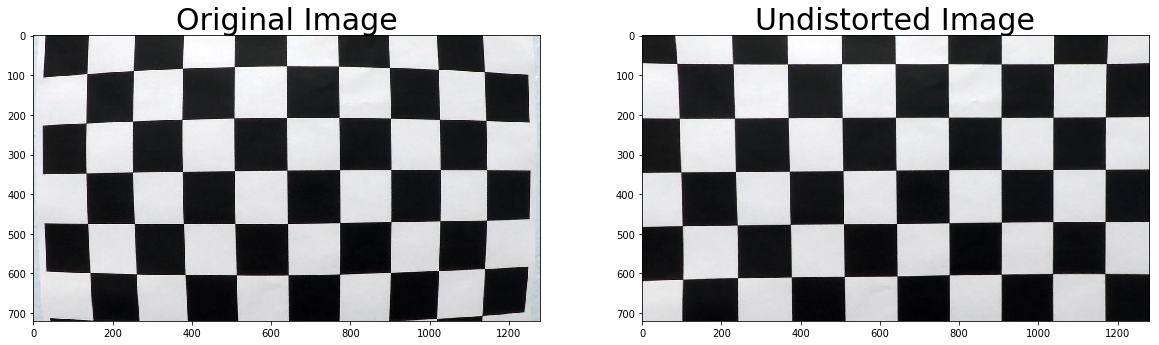

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/distored_undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [4]:
# Start Pipeline
def undistort(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

In [5]:
def binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    return combined_binary
    

In [6]:
def corners_unwarp(img, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    #undist = cv2.undistort(img, mtx, dist, None, mtx)        
    
    h,w = img.shape[:2]  
    
    
   
    
    src = np.float32([[w,h-10], #rd
                     [540,470], #lu
                     [740,470], #ru
                     [0, h-10]]) #ld
    dst= np.float32([[w,h], #rd
                     [0,0], #lu
                     [w,0], #ru
                     [0, h]]) #ld
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

dist_pickle = pickle.load( open( "camera_cal/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

def pipeline_img(img1, mtx, dist):
    
    # undistort image
    undist = undistort(img1, mtx, dist)
    
    # create binary
    binary_img = binary(undist, s_thresh=(170, 255), sx_thresh=(20, 100))
    
    # birdeye
    img_unwarped, M, Minv = corners_unwarp(binary_img, mtx, dist)
    
    return img_unwarped, M, Minv

In [8]:
def check_curvature(left_curverad, right_curverad):
    if right_curverad < 450 or left_curverad < 450:
        return False
    else:
        return True

def check_traces(left_coeffs, right_coeffs, prev_left_coeffs, prev_right_coeffs):
    if prev_left_coeffs == None or prev_right_coeffs == None:
        return True
    b_left = np.absolute(prev_left_coeffs[1] - left_coeffs[1])
    b_right = np.absolute(prev_right_coeffs[1] - right_coeffs[1])
    if b_left > 200 or b_right > 175:
        return False
    else:
        return True


In [9]:
prev_fit_left=None
prev_fit_right=None
pre_coeff_right=None
pre_coeff_left=None
count=0

In [10]:
def process_img(_img1):
    
    global prev_fit_left
    global prev_fit_right
    global pre_coeff_right
    global pre_coeff_left
    global count
    
    binary_warped, M, Minv= pipeline_img(_img1, mtx, dist)
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)    
    
    if (left_fit[1]<-1.3 or left_fit[1]>1.3 or right_fit[1]<-1.3 or right_fit[1]>1.3):
        if not (prev_fit_left==None and prev_fit_right==None):
            left_fit=prev_fit_left
            right_fit=prev_fit_right
    
    prev_fit_left=left_fit
    prev_fit_right=right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Determine curvature of the lane
    # Define y-value where we want radius of curvature
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2) ** 1.5) /(2 * left_fit[0]))
    right_curverad = np.absolute(((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5)  /(2 * right_fit[0]))
    curvature = (left_curverad + right_curverad) / 2
    min_curverad = min(left_curverad, right_curverad)
            
    # TODO: if plausible parallel, continue. Else don't make `curvature_checked` = True
    if not check_curvature(left_curverad, right_curverad) or not check_traces(left_fitx, right_fitx, pre_coeff_left, pre_coeff_right):
    
        if pre_coeff_left is not None and pre_coeff_right is not None:
            b_left = np.absolute(pre_coeff_left[1] - left_fitx[1])
            b_right = np.absolute(pre_coeff_right[1] - right_fitx[1])
            if b_left > 200 or b_right > 175:
                if b_left > 200:
                    left_fitx = pre_coeff_left 
                if b_right > 175:
                    right_fitx = pre_coeff_right    
            else: 
                right_fitx = pre_coeff_right    
                left_fitx = pre_coeff_left 
    
    pre_coeff_right=right_fitx
    pre_coeff_left=left_fitx
    
    undist = undistort(_img1, mtx, dist)
    warped = binary_warped
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (_img1.shape[1], _img1.shape[0])) 
        
    # Combine the result with the original image
    result_1 = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Convert from pixels to meters
    curvature = curvature / 128 * 3.7    
    cur_right =  right_curverad / 128 * 3.7
    cur_left =  left_curverad / 128 * 3.7
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result_1, 'Curvature = %d(m)' % curvature, (50, 50), font, 1, (255, 255, 255), 2)    
    cv2.putText(result_1, 'Points right/ left = %.3f %.3f' % (right_fitx[1], left_fitx[1]), (50, 150), font, 1, (255, 255, 255), 2)
    cv2.putText(result_1, 'Left poly coefficients = %.3f %.3f %.3f' % (left_fit[0], left_fit[1], left_fit[2]), (50, 200), font, 1, (255, 255, 255), 2)
    cv2.putText(result_1, 'Right poly coefficients = %.3f %.3f %.3f' % (right_fit[0], right_fit[1], right_fit[2]), (50, 250), font, 1, (255, 255, 255), 2)
 
    return result_1

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(img__):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = process_img(img__)
    
    return result

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [16:57<00:00,  1.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 17min 4s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))